## Dependencies

In [23]:
import weaviate
import weaviate.classes.config as wvcc
import weaviate.classes as wvc
from weaviate.classes.config import Property, DataType
from weaviate.util import generate_uuid5
from weaviate.auth import AuthApiKey

import os
import base64
from dotenv import load_dotenv, find_dotenv
import json
import requests
import PIL
# from PIL import Image as PILImage
from IPython.display import Image, display

from IPython.display import Image
from PIL import Image
from io import BytesIO
import google.generativeai as genai

## Connect to Weaviate

#### 1. Weaviate Cloud

The first option is the [Weaviate Cloud](https://console.weaviate.cloud/), you can connect your notebook to a serverless Weaviate to keep the data persistent in the cloud.

In [2]:
load_dotenv(find_dotenv()) # read local .env file
WCS_DEMO_URL = os.getenv("WCS_DEMO_URL")
WCS_DEMO_KEY = os.getenv("WCS_DEMO_KEY")
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
GEMINI_API_KEY=os.getenv("GEMINI_API_KEY")
PROJECT_ID=os.getenv("PROJECT_ID")

In [3]:
client = weaviate.connect_to_wcs(
    cluster_url=WCS_DEMO_URL, # URL to your cluster
    auth_credentials=AuthApiKey(WCS_DEMO_KEY), # Auth API key
    headers={
        "X-Google-Api-Key": GOOGLE_API_KEY, # Vertex API key
    }
)

client.is_connected()

True

#### 2. Running Weaviate on GKE

In [ ]:
client = weaviate.connect_to_custom(
            http_host=WEAVIATE_HTTP_URL,
            http_port="80",
            http_secure=False,
            grpc_host=WEAVIATE_GRPC_URL,
            grpc_port="50051",
            grpc_secure=False,
            auth_credentials=weaviate.auth.AuthApiKey(WEAVIATE_AUTH)
          )

## Configure Schema

In [7]:
if(client.collections.exists("Products")):
    client.collections.delete("Products") # CAUTION: running this again will delete your data

client.collections.create(
  name="Products",
  vectorizer_config=wvcc.Configure.Vectorizer.multi2vec_palm
  (
      text_fields=["description"], # property name to map to the description
      image_fields=["image"], # property name to map to the image
      
      project_id=PROJECT_ID, # google cloud project id
      location="us-central1", # region
      model_id="multimodalembedding@001" # multimodal model
  ),
   properties=[ # properties for the Products collection
          Property(name="title", data_type=DataType.TEXT),
          Property(name="category", data_type=DataType.TEXT),
          Property(name="link", data_type=DataType.TEXT),
          Property(name="description", data_type=DataType.TEXT),
          Property(name="image", data_type=DataType.BLOB),
          Property(name="generated_description", data_type=DataType.TEXT),
    ]
)

## Import Data

In [4]:
def url_to_base64(url):
    response = requests.get(url)
    return base64.b64encode(response.content).decode('utf-8')

url = 'https://raw.githubusercontent.com/bkauf/next-store/main/first_99_objects.json'
response = requests.get(url)

data = response.json()
data[0]

{'id': 'id_1',
 'product_id': 'GGOEGAYC135814',
 'title': 'Google Badge Tee',
 'category': 'Apparel  Accessories Tops  Tees Tshirts',
 'link': 'https://shop.googlemerchandisestore.com/store/20160512512/assets/items/images/GGOEGXXX1358.jpg',
 'description': 'A classic crew neck tee made from 100 cotton Its soft and comfortable and features a small Google logo on the chest',
 'color': "['Blue']",
 'gender': 'Unisex',
 'brand': 'Google'}

In [5]:
products = client.collections.get("Products")

with products.batch.dynamic() as batch:
  for item in data:
    image_link = item['link']
    base64_image = url_to_base64(image_link)

    properties={
      "title": item['title'],
      "category": item['category'],
      "link": item['link'],
      "description": item['description'],
      "image": base64_image
  }
    batch.add_object(
      properties=properties
)

In [6]:
products = client.collections.get("Products")
products.aggregate.over_all().total_count

99

## Query Time

### Helper Functions

In [32]:
def json_print(data):
    print(json.dumps(data, indent=2))

def display_image(url, size=100):
    response = requests.get(url)
    image_data = BytesIO(response.content)
    image = Image.open(image_data)
    
    resized_image = image.resize((size,size))

    display(resized_image)

def url_to_base64(url):
    image_response = requests.get(url)
    content = image_response.content
    return base64.b64encode(content).decode('utf-8')

def url_to_pil(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

### Hybrid Search

{
  "title": "Google Cloud Tshirt",
  "link": "https://shop.googlemerchandisestore.com/store/20190522377/assets/items/images/GGCPGXXX1000.jpg"
}


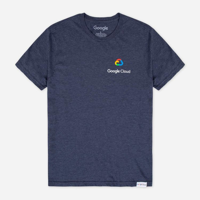

{
  "title": "Google Cloud Puffy Stickers",
  "link": "https://shop.googlemerchandisestore.com/store/20210125633/assets/items/images/GGEBCCBA101699.jpg"
}


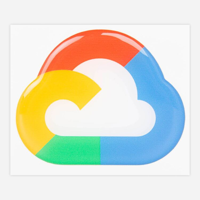

{
  "title": "Google Art Tote Bag",
  "link": "https://shop.googlemerchandisestore.com/store/20190522377/assets/items/images/GGCPGCBA145499.jpg"
}


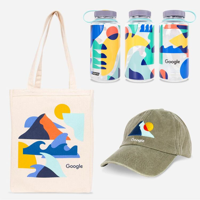

In [8]:
products = client.collections.get("Products")

response = products.query.hybrid(
    query="Google Cloud merch",
    alpha=0.75,
    return_properties=['title','link'],
    limit=3
)

for obj in response.objects:
    print(json.dumps(obj.properties, indent=2))
    display_image(obj.properties['link'], size=200)

### Image to Media Search

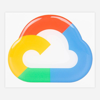

In [33]:
display_image("https://shop.googlemerchandisestore.com/store/20210125633/assets/items/images/GGEBCCBA101699.jpg")

{
  "title": "Google Cloud Puffy Stickers",
  "link": "https://shop.googlemerchandisestore.com/store/20210125633/assets/items/images/GGEBCCBA101699.jpg"
}


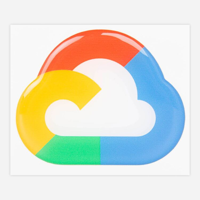

{
  "title": "Google Classic Sticker Sheet",
  "link": "https://shop.googlemerchandisestore.com/store/20160512512/assets/items/images/GGOEGFKA201499.jpg"
}


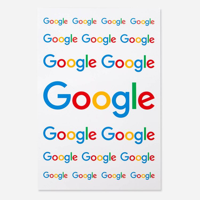

In [34]:
products = client.collections.get("Products")

response = products.query.near_image(
    near_image=url_to_base64("https://shop.googlemerchandisestore.com/store/20210125633/assets/items/images/GGEBCCBA101699.jpg"),
    return_properties=['title','link'],
    limit=2
)

for obj in response.objects:
    json_print(obj.properties)
    display_image(obj.properties['link'], size=200)

## Generative Search

### Connect and Configure Gemini Model

In [35]:
genai.configure(api_key=GEMINI_API_KEY) # Gemini API key from AI Studio

model = genai.GenerativeModel(model_name='gemini-1.5-flash-latest') 

### Simple Test

In [36]:
response = model.generate_content(
    "Can you come up with a clever group ice breaker?"
)

print(response.text)

##  Ice Breaker:  "The Story of Your Name" 

**Instructions:**

1. **Go around the circle and ask each person to tell a short, interesting story about the origin of their name.**  This could be:
    *  The meaning of their name
    *  A family member who inspired it
    *  A funny story about how they got their name
    *  Why they chose a nickname
    *  Any other personal connection to their name

2. **Encourage people to be creative and share something unique.**  It doesn't have to be a long story, just something that helps everyone learn a bit more about each other.

**Why it works:**

* **Personal:** It allows people to share something about themselves in a relaxed way.
* **Unique:** Everyone has a story about their name, making it a conversation starter.
* **Fun:** It's a lighthearted and engaging way to get to know each other.

**Bonus:** You can ask follow-up questions to keep the conversation flowing:

* "Is your name a family tradition?"
* "Do you like your name?"
* "Have you

### Generate Product Descriptions

https://shop.googlemerchandisestore.com/store/20190522377/assets/items/images/GGCPGXXX1593.jpg


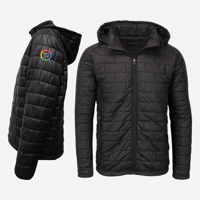

This lightweight and comfortable puffer jacket is perfect for any occasion. Featuring a quilted design for added warmth, it is ideal for transitioning between seasons. The hood provides extra protection from the elements, and the front zipper closure ensures a snug fit. With its sleek design and stylish black color, this jacket is perfect for men of all ages and styles.  The jacket also features a logo patch on the sleeve, which can be customized for your business or organization.
===
https://shop.googlemerchandisestore.com/store/20160512512/assets/items/images/GGOEGXXX2229.jpg


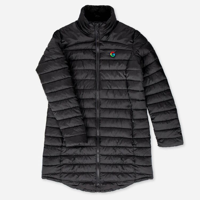

This black puffer jacket is perfect for keeping you warm and stylish all winter long. It features a high collar and a zipper closure, and it's made from a lightweight, water-resistant material. It has a sleek and modern design that will go with anything in your wardrobe. Whether you're running errands or going out for a night on the town, this jacket will keep you looking and feeling your best.
===
https://shop.googlemerchandisestore.com/store/20190522377/assets/items/images/GGCPGXXX1175.jpg


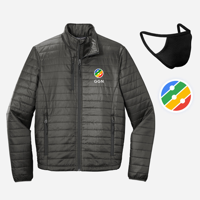

This is a black quilted jacket with a zipper closure and two zippered pockets. It features a company logo on the left chest. The jacket is paired with a black face mask.  This is a great option for employees to stay warm and comfortable while representing their company.
===


In [37]:
response = products.query.near_text(
    query="travel jacket",
    return_properties=["title", "description", "category", "link"],
    limit=3,
)

for product in response.objects:
    if "link" in product.properties:
        id = product.uuid
        img_url = product.properties["link"]

        pil_image = url_to_pil(img_url)
        generated_description = model.generate_content(["Write a short production description about this product", pil_image])
        generated_description = generated_description.text
        print(img_url)
        display_image(img_url, size=200)
        print(generated_description)
        print('===')

        # Update the product with the generated description
        products.data.update(uuid=id, properties={"generated_description": generated_description})

### Search on Generated Descriptions

{
  "description": "This jacket is a great addition to any wardrobe It is lightweight and waterresistant making it perfect for a variety of weather conditions The jacket also has a hood and zip pockets making it both stylish and functional",
  "title": "GTech Puffer Jacket",
  "generated_description": "This lightweight and comfortable puffer jacket is perfect for any occasion. Featuring a quilted design for added warmth, it is ideal for transitioning between seasons. The hood provides extra protection from the elements, and the front zipper closure ensures a snug fit. With its sleek design and stylish black color, this jacket is perfect for men of all ages and styles.  The jacket also features a logo patch on the sleeve, which can be customized for your business or organization.",
  "link": "https://shop.googlemerchandisestore.com/store/20190522377/assets/items/images/GGCPGXXX1593.jpg"
}


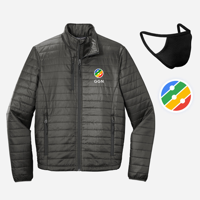

In [39]:
products = client.collections.get("Products")

response = products.query.near_text(
        query="lightweight jacket",
        return_properties=["generated_description", "description", "title", "link"],
        limit=1
    )

for o in response.objects:
    print(json.dumps(o.properties, indent=2))
    display_image(img_url, size=200)